## 1. Setup & Dependencies

### 1.1. Install Required Packages

In [1]:
# !pip install matplotlib
# !pip install pyserini
# !pip install faiss-cpu
# !pip install torch
# !pip install transformers
# !pip install sentence-transformers

In [2]:
import os
import re
import json
import warnings
from abc import ABC, abstractmethod
from typing import Dict, List, Tuple, Optional
from collections import defaultdict
from itertools import product
from functools import lru_cache

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
tqdm.pandas()

from pyserini.search.lucene import LuceneSearcher
from pyserini.index.lucene import IndexReader

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sentence_transformers import CrossEncoder

warnings.filterwarnings("ignore")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print("✓ Dependencies imported")

/home/galnoy/git-projects/MSC-Text-Retrieval-and-Search-Engines/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2026-01-09 17:11:55.600714268 [W:onnxruntime:Default, device_discovery.cc:164 DiscoverDevicesForPlatform] GPU device discovery failed: device_discovery.cc:89 ReadFileContents Failed to open file: "/sys/class/drm/card0/device/vendor"


Using device: cuda
✓ Dependencies imported


### 1.2. Load Pyserini Index

In [3]:
INDEX_NAME = "robust04"

index_reader = IndexReader.from_prebuilt_index(INDEX_NAME)

print(f"Index: {INDEX_NAME}")
print(f"Total documents: {index_reader.stats()['documents']:,}")
print(f"Total terms: {index_reader.stats()['total_terms']:,}")
print("✓ Pyserini index loaded")

Index: robust04
Total documents: 528,030
Total terms: 174,540,872
✓ Pyserini index loaded


Jan 09, 2026 5:11:56 PM org.apache.lucene.store.MemorySegmentIndexInputProvider <init>
INFO: Using MemorySegmentIndexInput with Java 21; to disable start with -Dorg.apache.lucene.store.MMapDirectory.enableMemorySegments=false


## 2. Data Loading

### 2.1. Load Queries

In [4]:
DATA_DIR = "./data/"

def load_queries(filepath: str) -> Dict[str, str]:
    """Load queries from file. Format: qid<tab>query_text"""
    queries = {}
    with open(filepath, "r") as f:
        for line in f:
            parts = line.strip().split("\t")
            if len(parts) == 2:
                qid, text = parts
                queries[qid] = text
    return queries

all_queries = load_queries(os.path.join(DATA_DIR, "queriesROBUST.txt"))

print(f"Total queries loaded: {len(all_queries)}")
print(f"\nSample queries:")
for qid, text in list(all_queries.items())[:5]:
    print(f"  {qid}: {text}")

Total queries loaded: 249

Sample queries:
  301: international organized crime
  302: poliomyelitis post polio
  303: hubble telescope achievements
  304: endangered species mammals
  305: dangerous vehicles


### 2.2. Load Relevance Judgments

In [5]:
def load_qrels(filepath: str) -> Dict[str, Dict[str, int]]:
    """Load qrels. Format: qid 0 docid relevance"""
    qrels = defaultdict(dict)
    with open(filepath, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 4:
                qid, _, docid, rel = parts[:4]
                qrels[qid][docid] = int(rel)
    return dict(qrels)

qrels = load_qrels(os.path.join(DATA_DIR, "qrels_50_Queries"))

print(f"Queries with relevance judgments: {len(qrels)}")
print(f"Total judgments: {sum(len(v) for v in qrels.values()):,}")

Queries with relevance judgments: 50
Total judgments: 61,511


### 2.3. Train/Test Split

In [6]:
train_qids = sorted(qrels.keys())
test_qids = [qid for qid in all_queries.keys() if qid not in train_qids]

train_queries = {qid: all_queries[qid] for qid in train_qids}
test_queries = {qid: all_queries[qid] for qid in test_qids}

print(f"Training queries: {len(train_queries)} (with qrels)")
print(f"Test queries: {len(test_queries)} (no qrels)")

Training queries: 50 (with qrels)
Test queries: 199 (no qrels)


## 3. Evaluation Metrics

In [7]:
def compute_ap(ranked_docs: List[str], relevance: Dict[str, int]) -> float:
    """Compute Average Precision for a single query."""
    relevant = {d for d, r in relevance.items() if r > 0}
    if not relevant:
        return 0.0
    
    hits = 0
    precision_sum = 0.0
    
    for i, doc in enumerate(ranked_docs):
        if doc in relevant:
            hits += 1
            precision_sum += hits / (i + 1)
    
    return precision_sum / len(relevant)


def compute_map(
    run: Dict[str, List[Tuple[str, float]]],
    qrels: Dict[str, Dict[str, int]]
) -> float:
    """Compute Mean Average Precision over all queries."""
    aps = []
    for qid, results in run.items():
        if qid in qrels:
            ranked_docs = [doc for doc, _ in results]
            ap = compute_ap(ranked_docs, qrels[qid])
            aps.append(ap)
    return np.mean(aps) if aps else 0.0


def evaluate_run(
    run: Dict[str, List[Tuple[str, float]]],
    qrels: Dict[str, Dict[str, int]]
) -> Dict[str, float]:
    """Evaluate a run and return metrics."""
    map_score = compute_map(run, qrels)
    
    per_query = {}
    for qid in run:
        if qid in qrels:
            ranked = [d for d, _ in run[qid]]
            per_query[qid] = compute_ap(ranked, qrels[qid])
    
    return {
        "map": map_score,
        "num_queries": len(per_query),
        "per_query_ap": per_query
    }


print("✓ Evaluation metrics defined")

✓ Evaluation metrics defined


## 4. Retrieval Models

### 4.1. Abstract Base Class

In [8]:
class BaseRetriever(ABC):
    """
    Abstract base class for all retrieval models.
    All models must implement search.
    """
    
    def __init__(self, index_name: str = "robust04"):
        self.index_name = index_name
    
    @abstractmethod
    def search(
        self,
        queries: Dict[str, str],
        k: int = 1000
    ) -> Dict[str, List[Tuple[str, float]]]:
        """Search for all queries and return ranked results."""
        pass
    
    def get_params(self) -> Dict:
        """Return model parameters for logging."""
        return {}


print("✓ BaseRetriever class defined")

✓ BaseRetriever class defined


### 4.2. BM25 Retriever

In [9]:
class BM25Retriever(BaseRetriever):
    """
    BM25 retrieval model.
    
    BM25 score = sum over terms t in q:
        IDF(t) * (tf(t,d) * (k1 + 1)) / (tf(t,d) + k1 * (1 - b + b * |d|/avgdl))
    """
    
    def __init__(
        self,
        k1: float = 0.9,
        b: float = 0.4,
        index_name: str = "robust04"
    ):
        super().__init__(index_name)
        self.k1 = k1
        self.b = b
        self._searcher = None
    
    @property
    def searcher(self) -> LuceneSearcher:
        if self._searcher is None:
            self._searcher = LuceneSearcher.from_prebuilt_index(self.index_name)
            self._searcher.set_bm25(k1=self.k1, b=self.b)
        return self._searcher
    
    def search(
        self,
        queries: Dict[str, str],
        k: int = 1000
    ) -> Dict[str, List[Tuple[str, float]]]:
        results = {}
        for qid, query_text in tqdm(queries.items(), desc="BM25 Search"):
            hits = self.searcher.search(query_text, k=k)
            results[qid] = [(hit.docid, hit.score) for hit in hits]
        return results
    
    def get_params(self) -> Dict:
        return {"k1": self.k1, "b": self.b}


print("✓ BM25Retriever class defined")

✓ BM25Retriever class defined


### 4.3. BM25 + RM3 Retriever (Query Expansion)

In [10]:
class RM3Retriever(BaseRetriever):
    """
    BM25 + RM3 pseudo-relevance feedback.
    
    RM3 expands the query using terms from top-k retrieved documents.
    Final query = original_weight * original_query + (1 - original_weight) * expansion_terms
    """
    
    def __init__(
        self,
        k1: float = 0.9,
        b: float = 0.4,
        fb_terms: int = 10,
        fb_docs: int = 10,
        original_weight: float = 0.5,
        index_name: str = "robust04"
    ):
        super().__init__(index_name)
        self.k1 = k1
        self.b = b
        self.fb_terms = fb_terms
        self.fb_docs = fb_docs
        self.original_weight = original_weight
        self._searcher = None
    
    @property
    def searcher(self) -> LuceneSearcher:
        if self._searcher is None:
            self._searcher = LuceneSearcher.from_prebuilt_index(self.index_name)
            self._searcher.set_bm25(k1=self.k1, b=self.b)
            self._searcher.set_rm3(
                fb_terms=self.fb_terms,
                fb_docs=self.fb_docs,
                original_query_weight=self.original_weight
            )
        return self._searcher
    
    def search(
        self,
        queries: Dict[str, str],
        k: int = 1000
    ) -> Dict[str, List[Tuple[str, float]]]:
        results = {}
        for qid, query_text in tqdm(queries.items(), desc="RM3 Search"):
            hits = self.searcher.search(query_text, k=k)
            results[qid] = [(hit.docid, hit.score) for hit in hits]
        return results
    
    def get_params(self) -> Dict:
        return {
            "k1": self.k1,
            "b": self.b,
            "fb_terms": self.fb_terms,
            "fb_docs": self.fb_docs,
            "original_weight": self.original_weight
        }


print("✓ RM3Retriever class defined")

✓ RM3Retriever class defined


### 4.4. Advanced Hybrid Retriever (BM25+RM3, QLD+RM3, Passages, RRF)

This method combines multiple retrieval signals:
- BM25 with RM3 query expansion
- Query Likelihood (QLD) with RM3 query expansion
- Document-level RRF fusion: $\text{RRF}(d) = \sum_{r \in R} \frac{1}{k + \text{rank}_r(d)}$
- Passage-level splitting with overlapping windows
- Cross-encoder passage reranking
- Passage-to-document score aggregation

In [ ]:
from functools import lru_cache
from sentence_transformers import CrossEncoder


TEXT_RE = re.compile(r'<TEXT>(.*?)</TEXT>', re.DOTALL | re.IGNORECASE)

@lru_cache(maxsize=2000)
def get_doc_content(docid: str, searcher: LuceneSearcher) -> str:
    doc = searcher.doc(docid)
    if doc is None:
        return ""

    raw = doc.raw() or ""

    # Robust04 is TREC; just parse TEXT tags
    texts = TEXT_RE.findall(raw)
    if texts:
        content = " ".join(texts)
    else:
        # Fallback: strip tags and return whatever text remains
        content = re.sub(r'<[^>]+>', ' ', raw)

    # Normalize whitespace
    content = re.sub(r'\s+', ' ', content).strip()
    return content


class AdvancedHybridRetriever(BaseRetriever):
    """
    Advanced hybrid retrieval combining:
      1. BM25 + RM3 query expansion (first-stage)
      2. QLD + RM3 query expansion (first-stage)
      3. Document-level RRF fusion
      4. Passage extraction with overlapping windows
      5. Cross-encoder passage reranking
      6. Passage-to-document score aggregation
    
    This approach balances recall (multiple retrieval models) with precision
    (passage-level neural reranking).
    """
    
    def __init__(
        self,
        # BM25 params
        k1: float = 0.9,
        b: float = 0.4,
        
        # QLD params
        mu: int = 1000,
        
        # RM3 params
        fb_terms: int = 10,
        fb_docs: int = 10,
        original_weight: float = 0.5,
        
        # Retrieval params
        k_docs: int = 100,
        rrf_k: int = 60,
        
        # Passage params
        window: int = 150,
        overlap: int = 50,
        min_passage_words: int = 30,
        
        # Reranking params
        model_name: str = "cross-encoder/ms-marco-MiniLM-L-6-v2",
        batch_size: int = 32,
        
        index_name: str = "robust04"
    ):
        super().__init__(index_name)
        self.k1 = k1
        self.b = b
        self.mu = mu
        self.fb_terms = fb_terms
        self.fb_docs = fb_docs
        self.original_weight = original_weight
        self.k_docs = k_docs
        self.rrf_k = rrf_k
        self.window = window
        self.overlap = overlap
        self.min_passage_words = min_passage_words
        self.rerank_top_passages = k_docs * 5
        self.model_name = model_name
        self.batch_size = batch_size
        
        self._bm25_searcher = None
        self._qld_searcher = None
        self._cross_encoder = None
    
    @property
    def bm25_searcher(self) -> LuceneSearcher:
        """BM25 + RM3 searcher."""
        if self._bm25_searcher is None:
            self._bm25_searcher = LuceneSearcher.from_prebuilt_index(self.index_name)
            self._bm25_searcher.set_bm25(k1=self.k1, b=self.b)
            self._bm25_searcher.set_rm3(
                fb_terms=self.fb_terms,
                fb_docs=self.fb_docs,
                original_query_weight=self.original_weight
            )
        return self._bm25_searcher
    
    @property
    def qld_searcher(self) -> LuceneSearcher:
        """QLD + RM3 searcher."""
        if self._qld_searcher is None:
            self._qld_searcher = LuceneSearcher.from_prebuilt_index(self.index_name)
            self._qld_searcher.set_qld(mu=self.mu)
            self._qld_searcher.set_rm3(
                fb_terms=self.fb_terms,
                fb_docs=self.fb_docs,
                original_query_weight=self.original_weight
            )
        return self._qld_searcher
    
    @property
    def cross_encoder(self):
        """Lazy-loaded cross-encoder model."""
        if self._cross_encoder is None:
            self._cross_encoder = CrossEncoder(
                self.model_name,
                model_kwargs={"dtype": torch.float16},
                device=DEVICE,
                max_length=512,
            )
        return self._cross_encoder
    
    def extract_passages(self, text: str) -> List[str]:
        """
        Split document into overlapping passages.
        Uses word-level sliding window for better context preservation.
        """
        if not text:
            return []
        
        words = text.split()
        if len(words) < self.min_passage_words:
            return []
        
        step = max(1, self.window - self.overlap)
        passages = []
        
        for i in range(0, len(words), step):
            chunk = words[i:i + self.window]
            if len(chunk) < self.min_passage_words:
                break
            passages.append(" ".join(chunk))
        
        return passages
    
    def rrf_fusion(self, rankings: List[List[Tuple[str, float]]]) -> Dict[str, float]:
        """
        Reciprocal Rank Fusion: combines multiple rankings.
        Returns dict of {docid: rrf_score}.
        """
        rrf_scores = defaultdict(float)
        
        for ranking in rankings:
            for rank, (docid, _) in enumerate(ranking):
                rrf_scores[docid] += 1.0 / (self.rrf_k + rank + 1)
        
        return dict(rrf_scores)
    
    def rerank_passages(self, query: str, docid_to_passages: Dict[str, List[str]]) -> Dict[str, float]:
        """
        Cross-encoder passage reranking.
        Returns {docid: max_passage_score}.
        """

        if not docid_to_passages:
            return {}

        pairs = []
        pair_docids = []

        for docid, passages in docid_to_passages.items():
            for p in passages:
                pairs.append([query, p])
                pair_docids.append(docid)

        if not pairs:
            return {}

        with torch.inference_mode():
            scores = self.cross_encoder.predict(
                pairs,
                batch_size=self.batch_size,
                show_progress_bar=False,
            )

        doc_scores: Dict[str, float] = {}

        for docid, score in zip(pair_docids, scores):
            prev = doc_scores.get(docid, float("-inf"))
            if score > prev:
                doc_scores[docid] = float(score)

        return doc_scores
        
    def search(
        self,
        queries: Dict[str, str],
        k: int = 1000
    ) -> Dict[str, List[Tuple[str, float]]]:
        results: Dict[str, List[Tuple[str, float]]] = {}

        for qid, query_text in tqdm(queries.items(), desc="Advanced Hybrid Search"):
            # Stage 1: First-stage lexical retrieval
            bm25_hits = self.bm25_searcher.search(query_text, k=self.k_docs)
            bm25_ranking = [(h.docid, h.score) for h in bm25_hits]

            qld_hits = self.qld_searcher.search(query_text, k=self.k_docs)
            qld_ranking = [(h.docid, h.score) for h in qld_hits]

            # Stage 2: Document-level RRF fusion
            doc_scores = self.rrf_fusion([bm25_ranking, qld_ranking])
            ranked_docids = sorted(
                doc_scores,
                key=doc_scores.get,
                reverse=True,
            )

            # Stage 3: Passage extraction (GLOBAL CAP = 5 * k_docs)
            docid_to_passages: Dict[str, List[str]] = {}
            max_passages = self.rerank_top_passages
            total_passages = 0

            for docid in ranked_docids[:self.k_docs]:
                if total_passages >= max_passages:
                    break

                content = get_doc_content(docid, self.bm25_searcher)
                if not content:
                    continue

                passages = self.extract_passages(content)
                if not passages:
                    continue

                remaining = max_passages - total_passages
                passages = passages[:remaining]

                docid_to_passages[docid] = passages
                total_passages += len(passages)

            # Stage 4: Cross-encoder passage reranking
            reranked_scores = self.rerank_passages(
                query=query_text,
                docid_to_passages=docid_to_passages,
            )

            # Stage 5: Final document scoring
            final_doc_scores = reranked_scores if reranked_scores else doc_scores

            ranked = sorted(
                final_doc_scores.items(),
                key=lambda x: x[1],
                reverse=True,
            )

            # Stage 6: Pad with BM25 tail to reach k documents
            if len(ranked) < k:
                seen = {docid for docid, _ in ranked}
                extra_hits = self.bm25_searcher.search(query_text, k=k)

                for hit in extra_hits:
                    if hit.docid not in seen:
                        ranked.append((hit.docid, hit.score))
                        if len(ranked) >= k:
                            break

            results[qid] = ranked[:k]

        return results

    
    def get_params(self) -> Dict:
        return {
            "k1": self.k1,
            "b": self.b,
            "mu": self.mu,
            "fb_terms": self.fb_terms,
            "fb_docs": self.fb_docs,
            "original_weight": self.original_weight,
            "k_docs": self.k_docs,
            "rrf_k": self.rrf_k,
            "window": self.window,
            "overlap": self.overlap,
            "model_name": self.model_name
        }


print("✓ AdvancedHybridRetriever class defined")

✓ AdvancedHybridRetriever class defined


## 5. Hyperparameter Tuning

### 5.1. Experiment Caching Utils

In [12]:
RESULTS_CSV = "./experiments.csv"


def generate_config_key(model_name: str, params: Dict) -> str:
    """Generate a unique config key per model + params."""
    parts = [model_name]
    for k, v in sorted(params.items()):
        if k not in ["index_name", "model_name", "batch_size"]:
            parts.append(f"{k}={v}")
    return "__".join(parts)


def load_completed_experiments() -> pd.DataFrame:
    if not os.path.exists(RESULTS_CSV):
        return pd.DataFrame()
    return pd.read_csv(RESULTS_CSV)


def load_cached_result(config_key: str) -> Optional[Dict]:
    df = load_completed_experiments()
    if df.empty:
        return None
    row = df[df["config_key"] == config_key]
    if row.empty:
        return None
    return row.iloc[0].to_dict()


def save_experiment_result(result: Dict):
    df_row = pd.DataFrame([result])
    if not os.path.exists(RESULTS_CSV):
        df_row.to_csv(RESULTS_CSV, index=False)
    else:
        df_row.to_csv(RESULTS_CSV, mode="a", header=False, index=False)


print("✓ Caching utils ready")
print(f"  Results CSV: {RESULTS_CSV}")

✓ Caching utils ready
  Results CSV: ./experiments.csv


### 5.2. Experiment Framework

In [13]:
def run_experiment(
    config_key: str,
    model_name: str,
    model_class: type,
    model_params: Dict,
    queries: Dict[str, str],
    qrels: Dict[str, Dict[str, int]]
) -> Dict:
    """Run a single experiment and return results."""
    model = model_class(**model_params)
    run = model.search(queries, k=1000)
    metrics = evaluate_run(run, qrels)
    
    return {
        "config_key": config_key,
        "model": model_name,
        "map": metrics["map"],
        "num_queries": metrics["num_queries"]
    }


print("✓ Experiment framework ready")

✓ Experiment framework ready


### 5.3. Hyperparameter Grid Search

In [14]:
from itertools import product

EXPERIMENTS = [
    # --------------------------------------------------
    # 1) BM25 — strong lexical baseline
    # --------------------------------------------------
    {
        "model_name": "BM25",
        "model_class": BM25Retriever,
        "param_grid": [
            {"k1": k1, "b": b}
            for k1, b in product(
                [0.6, 0.9, 1.2, 1.5, 2.0],
                [0.3, 0.4, 0.5, 0.6, 0.75]
            )
        ],
    },

    # --------------------------------------------------
    # 2) BM25 + RM3 — tuned PRF
    # --------------------------------------------------
    {
        "model_name": "RM3",
        "model_class": RM3Retriever,
        "param_grid": [
            {"k1": 0.9, "b": 0.4, "fb_terms": fb_terms, "fb_docs": fb_docs, "original_weight": orig_w}
            for fb_terms, fb_docs, orig_w in product(
                [10, 20, 30],
                [5, 10, 15],
                [0.3, 0.5, 0.7]
            )
        ],
    },

    # --------------------------------------------------
    # 3) Advanced Hybrid — RRF + passage CE reranking
    # --------------------------------------------------
    {
        "model_name": "AdvancedHybrid",
        "model_class": AdvancedHybridRetriever,
        "param_grid": [
            {
                "k1": 0.9,
                "b": 0.4,
                "mu": mu,
                "fb_terms": 10,
                "fb_docs": 10,
                "original_weight": 0.5,
                "k_docs": k_docs,
                "window": window,
                "overlap": overlap,
            }
            for mu, k_docs, window, overlap in product(
                [1000, 2000],
                [100, 250, 500],
                [150, 250],
                [30, 50]
            )
        ],
    },
]

print("Total experiments configured:")
for exp in EXPERIMENTS:
    print(f"  {exp['model_name']}: {len(exp['param_grid'])} configurations")

Total experiments configured:
  BM25: 25 configurations
  RM3: 27 configurations
  AdvancedHybrid: 24 configurations


In [15]:
results = []

for exp in EXPERIMENTS:
    model_name = exp["model_name"]
    model_class = exp["model_class"]
    
    for params in exp["param_grid"]:
        config_key = generate_config_key(model_name, params)
        
        print("\n" + "=" * 60)
        print(f"Experiment: {config_key}")
        print(f"Model: {model_name}")
        print("=" * 60)
        
        cached = load_cached_result(config_key)
        if cached is not None:
            print("✓ Loaded from cache")
            result = cached
        else:
            result = run_experiment(
                config_key=config_key,
                model_name=model_name,
                model_class=model_class,
                model_params=params,
                queries=train_queries,
                qrels=qrels
            )
            save_experiment_result(result)
        
        print(f"\nResults:")
        print(f"  MAP: {result['map']:.4f}")
        
        results.append(result)

print("\n" + "=" * 60)
print("All experiments completed.")
print("=" * 60)


Experiment: BM25__b=0.3__k1=0.6
Model: BM25
✓ Loaded from cache

Results:
  MAP: 0.2463

Experiment: BM25__b=0.4__k1=0.6
Model: BM25
✓ Loaded from cache

Results:
  MAP: 0.2475

Experiment: BM25__b=0.5__k1=0.6
Model: BM25
✓ Loaded from cache

Results:
  MAP: 0.2453

Experiment: BM25__b=0.6__k1=0.6
Model: BM25
✓ Loaded from cache

Results:
  MAP: 0.2422

Experiment: BM25__b=0.75__k1=0.6
Model: BM25
✓ Loaded from cache

Results:
  MAP: 0.2392

Experiment: BM25__b=0.3__k1=0.9
Model: BM25
✓ Loaded from cache

Results:
  MAP: 0.2450

Experiment: BM25__b=0.4__k1=0.9
Model: BM25
✓ Loaded from cache

Results:
  MAP: 0.2455

Experiment: BM25__b=0.5__k1=0.9
Model: BM25
✓ Loaded from cache

Results:
  MAP: 0.2442

Experiment: BM25__b=0.6__k1=0.9
Model: BM25
✓ Loaded from cache

Results:
  MAP: 0.2415

Experiment: BM25__b=0.75__k1=0.9
Model: BM25
✓ Loaded from cache

Results:
  MAP: 0.2374

Experiment: BM25__b=0.3__k1=1.2
Model: BM25
✓ Loaded from cache

Results:
  MAP: 0.2426

Experiment: BM25__

Advanced Hybrid Search:   0%|          | 0/50 [00:00<?, ?it/s]

Advanced Hybrid Search: 100%|██████████| 50/50 [01:49<00:00,  2.19s/it]



Results:
  MAP: 0.2834

Experiment: AdvancedHybrid__b=0.4__fb_docs=10__fb_terms=10__k1=0.9__k_docs=500__mu=1000__original_weight=0.5__overlap=30__window=150
Model: AdvancedHybrid


Advanced Hybrid Search: 100%|██████████| 50/50 [02:36<00:00,  3.14s/it]



Results:
  MAP: 0.2985

Experiment: AdvancedHybrid__b=0.4__fb_docs=10__fb_terms=10__k1=0.9__k_docs=500__mu=1000__original_weight=0.5__overlap=50__window=150
Model: AdvancedHybrid


Advanced Hybrid Search: 100%|██████████| 50/50 [02:32<00:00,  3.04s/it]



Results:
  MAP: 0.3018

Experiment: AdvancedHybrid__b=0.4__fb_docs=10__fb_terms=10__k1=0.9__k_docs=500__mu=1000__original_weight=0.5__overlap=30__window=250
Model: AdvancedHybrid


Advanced Hybrid Search: 100%|██████████| 50/50 [03:20<00:00,  4.00s/it]



Results:
  MAP: 0.2905

Experiment: AdvancedHybrid__b=0.4__fb_docs=10__fb_terms=10__k1=0.9__k_docs=500__mu=1000__original_weight=0.5__overlap=50__window=250
Model: AdvancedHybrid


Advanced Hybrid Search: 100%|██████████| 50/50 [03:27<00:00,  4.14s/it]



Results:
  MAP: 0.2834

Experiment: AdvancedHybrid__b=0.4__fb_docs=10__fb_terms=10__k1=0.9__k_docs=100__mu=2000__original_weight=0.5__overlap=30__window=150
Model: AdvancedHybrid


Advanced Hybrid Search: 100%|██████████| 50/50 [00:39<00:00,  1.28it/s]



Results:
  MAP: 0.2838

Experiment: AdvancedHybrid__b=0.4__fb_docs=10__fb_terms=10__k1=0.9__k_docs=100__mu=2000__original_weight=0.5__overlap=50__window=150
Model: AdvancedHybrid


Advanced Hybrid Search: 100%|██████████| 50/50 [00:38<00:00,  1.31it/s]



Results:
  MAP: 0.2820

Experiment: AdvancedHybrid__b=0.4__fb_docs=10__fb_terms=10__k1=0.9__k_docs=100__mu=2000__original_weight=0.5__overlap=30__window=250
Model: AdvancedHybrid


Advanced Hybrid Search: 100%|██████████| 50/50 [00:48<00:00,  1.04it/s]



Results:
  MAP: 0.2794

Experiment: AdvancedHybrid__b=0.4__fb_docs=10__fb_terms=10__k1=0.9__k_docs=100__mu=2000__original_weight=0.5__overlap=50__window=250
Model: AdvancedHybrid


Advanced Hybrid Search: 100%|██████████| 50/50 [00:48<00:00,  1.03it/s]



Results:
  MAP: 0.2740

Experiment: AdvancedHybrid__b=0.4__fb_docs=10__fb_terms=10__k1=0.9__k_docs=250__mu=2000__original_weight=0.5__overlap=30__window=150
Model: AdvancedHybrid


Advanced Hybrid Search: 100%|██████████| 50/50 [01:26<00:00,  1.74s/it]



Results:
  MAP: 0.2941

Experiment: AdvancedHybrid__b=0.4__fb_docs=10__fb_terms=10__k1=0.9__k_docs=250__mu=2000__original_weight=0.5__overlap=50__window=150
Model: AdvancedHybrid


Advanced Hybrid Search: 100%|██████████| 50/50 [01:23<00:00,  1.67s/it]



Results:
  MAP: 0.2941

Experiment: AdvancedHybrid__b=0.4__fb_docs=10__fb_terms=10__k1=0.9__k_docs=250__mu=2000__original_weight=0.5__overlap=30__window=250
Model: AdvancedHybrid


Advanced Hybrid Search: 100%|██████████| 50/50 [01:48<00:00,  2.17s/it]



Results:
  MAP: 0.2829

Experiment: AdvancedHybrid__b=0.4__fb_docs=10__fb_terms=10__k1=0.9__k_docs=250__mu=2000__original_weight=0.5__overlap=50__window=250
Model: AdvancedHybrid


Advanced Hybrid Search: 100%|██████████| 50/50 [01:48<00:00,  2.17s/it]



Results:
  MAP: 0.2828

Experiment: AdvancedHybrid__b=0.4__fb_docs=10__fb_terms=10__k1=0.9__k_docs=500__mu=2000__original_weight=0.5__overlap=30__window=150
Model: AdvancedHybrid


Advanced Hybrid Search: 100%|██████████| 50/50 [02:44<00:00,  3.29s/it]



Results:
  MAP: 0.2970

Experiment: AdvancedHybrid__b=0.4__fb_docs=10__fb_terms=10__k1=0.9__k_docs=500__mu=2000__original_weight=0.5__overlap=50__window=150
Model: AdvancedHybrid


Advanced Hybrid Search: 100%|██████████| 50/50 [02:37<00:00,  3.14s/it]



Results:
  MAP: 0.2987

Experiment: AdvancedHybrid__b=0.4__fb_docs=10__fb_terms=10__k1=0.9__k_docs=500__mu=2000__original_weight=0.5__overlap=30__window=250
Model: AdvancedHybrid


Advanced Hybrid Search: 100%|██████████| 50/50 [03:24<00:00,  4.10s/it]



Results:
  MAP: 0.2875

Experiment: AdvancedHybrid__b=0.4__fb_docs=10__fb_terms=10__k1=0.9__k_docs=500__mu=2000__original_weight=0.5__overlap=50__window=250
Model: AdvancedHybrid


Advanced Hybrid Search: 100%|██████████| 50/50 [03:24<00:00,  4.10s/it]


Results:
  MAP: 0.2803

All experiments completed.


In [16]:
results_sorted = sorted(results, key=lambda x: x["map"], reverse=True)
top_k = results_sorted[:10]

print("\n" + "=" * 100)
print("Top 10 Results (sorted by MAP):")
print("=" * 100)

header = f"{'#':<3} {'Model':<15} {'MAP':>10} {'Config':<70}"
print(header)
print("-" * len(header))

for i, r in enumerate(top_k, start=1):
    print(
        f"{i:<3} "
        f"{r['model']:<15} "
        f"{r['map']:>10.4f} "
        f"{r['config_key']:<70}"
    )


Top 10 Results (sorted by MAP):
#   Model                  MAP Config                                                                
-----------------------------------------------------------------------------------------------------
1   AdvancedHybrid      0.3018 AdvancedHybrid__b=0.4__fb_docs=10__fb_terms=10__k1=0.9__k_docs=500__mu=1000__original_weight=0.5__overlap=50__window=150
2   AdvancedHybrid      0.2987 AdvancedHybrid__b=0.4__fb_docs=10__fb_terms=10__k1=0.9__k_docs=500__mu=2000__original_weight=0.5__overlap=50__window=150
3   AdvancedHybrid      0.2985 AdvancedHybrid__b=0.4__fb_docs=10__fb_terms=10__k1=0.9__k_docs=500__mu=1000__original_weight=0.5__overlap=30__window=150
4   AdvancedHybrid      0.2979 AdvancedHybrid__b=0.4__fb_docs=10__fb_terms=10__k1=0.9__k_docs=250__mu=1000__original_weight=0.5__overlap=50__window=150
5   AdvancedHybrid      0.2970 AdvancedHybrid__b=0.4__fb_docs=10__fb_terms=10__k1=0.9__k_docs=500__mu=2000__original_weight=0.5__overlap=30__window=150
6  

## 6. Results Summary

### 6.1. Best Model per Method

In [17]:
# Find best config for each model type
best_per_model = {}
for r in results_sorted:
    model = r["model"]
    if model not in best_per_model:
        best_per_model[model] = r

print("Best configuration per model:")
print("=" * 80)
for model, r in best_per_model.items():
    print(f"\n{model}:")
    print(f"  MAP: {r['map']:.4f}")
    print(f"  Config: {r['config_key']}")

Best configuration per model:

AdvancedHybrid:
  MAP: 0.3018
  Config: AdvancedHybrid__b=0.4__fb_docs=10__fb_terms=10__k1=0.9__k_docs=500__mu=1000__original_weight=0.5__overlap=50__window=150

RM3:
  MAP: 0.2719
  Config: RM3__b=0.4__fb_docs=5__fb_terms=20__k1=0.9__original_weight=0.5

BM25:
  MAP: 0.2475
  Config: BM25__b=0.4__k1=0.6


### 6.2. Training Performance Comparison

In [18]:
summary_data = []
for model, r in best_per_model.items():
    summary_data.append({
        "Method": model,
        "MAP": r["map"],
        "Config": r["config_key"]
    })

summary_df = pd.DataFrame(summary_data).sort_values("MAP", ascending=False)

print("=" * 100)
print("TRAINING PERFORMANCE SUMMARY (50 queries)")
print("=" * 100)
print(summary_df.to_string(index=False))
print("=" * 100)

TRAINING PERFORMANCE SUMMARY (50 queries)
        Method      MAP                                                                                                                   Config
AdvancedHybrid 0.301796 AdvancedHybrid__b=0.4__fb_docs=10__fb_terms=10__k1=0.9__k_docs=500__mu=1000__original_weight=0.5__overlap=50__window=150
           RM3 0.271865                                                          RM3__b=0.4__fb_docs=5__fb_terms=20__k1=0.9__original_weight=0.5
          BM25 0.247464                                                                                                      BM25__b=0.4__k1=0.6


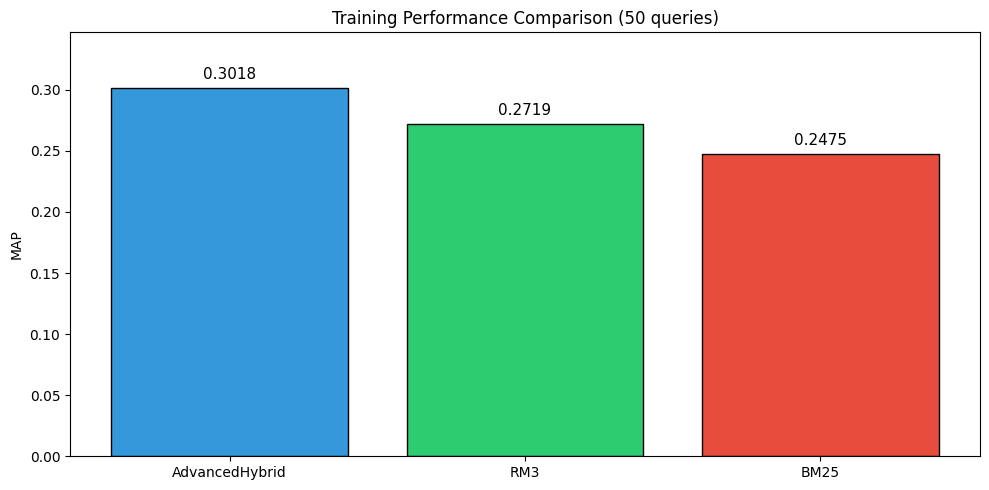

In [19]:
fig, ax = plt.subplots(figsize=(10, 5))

methods = summary_df["Method"].tolist()
maps = summary_df["MAP"].tolist()
colors = ["#3498db", "#2ecc71", "#e74c3c"]

bars = ax.bar(methods, maps, color=colors[:len(methods)], edgecolor="black")
ax.set_ylabel("MAP")
ax.set_title("Training Performance Comparison (50 queries)")
ax.set_ylim(0, max(maps) * 1.15)

for bar, m in zip(bars, maps):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
            f"{m:.4f}", ha="center", va="bottom", fontsize=11)

plt.tight_layout()
plt.show()

## 7. Final Model Selection

In [20]:
# Select best overall model
best_result = results_sorted[0]

print("Best model from all experiments:")
print(f"  Model: {best_result['model']}")
print(f"  MAP: {best_result['map']:.4f}")
print(f"  Config: {best_result['config_key']}")

# Find matching experiment configuration
best_model_name = best_result["model"]
best_config_key = best_result["config_key"]

matched_config = None
matched_model_class = None

for exp in EXPERIMENTS:
    if exp["model_name"] == best_model_name:
        matched_model_class = exp["model_class"]
        for params in exp["param_grid"]:
            config_key = generate_config_key(exp["model_name"], params)
            if config_key == best_config_key:
                matched_config = params.copy()
                break
        if matched_config:
            break

if matched_config is None:
    raise ValueError(f"Could not find matching config for {best_config_key}")

print(f"\n✓ Best model identified: {best_model_name}")
print(f"  Parameters: {matched_config}")

Best model from all experiments:
  Model: AdvancedHybrid
  MAP: 0.3018
  Config: AdvancedHybrid__b=0.4__fb_docs=10__fb_terms=10__k1=0.9__k_docs=500__mu=1000__original_weight=0.5__overlap=50__window=150

✓ Best model identified: AdvancedHybrid
  Parameters: {'k1': 0.9, 'b': 0.4, 'mu': 1000, 'fb_terms': 10, 'fb_docs': 10, 'original_weight': 0.5, 'k_docs': 500, 'window': 150, 'overlap': 50}


## 8. Generate Submission Files

### 8.1. Initialize Final Models

In [21]:
# Get best parameters for each method
best_bm25_params = None
best_rm3_params = None
best_advanced_params = None

for model_name, r in best_per_model.items():
    for exp in EXPERIMENTS:
        if exp["model_name"] == model_name:
            for params in exp["param_grid"]:
                if generate_config_key(model_name, params) == r["config_key"]:
                    if model_name == "BM25":
                        best_bm25_params = params
                    elif model_name == "RM3":
                        best_rm3_params = params
                    elif model_name == "AdvancedHybrid":
                        best_advanced_params = params
                    break

print("Final model configurations:")
print(f"  BM25: {best_bm25_params}")
print(f"  RM3: {best_rm3_params}")
print(f"  AdvancedHybrid: {best_advanced_params}")

Final model configurations:
  BM25: {'k1': 0.6, 'b': 0.4}
  RM3: {'k1': 0.9, 'b': 0.4, 'fb_terms': 20, 'fb_docs': 5, 'original_weight': 0.5}
  AdvancedHybrid: {'k1': 0.9, 'b': 0.4, 'mu': 1000, 'fb_terms': 10, 'fb_docs': 10, 'original_weight': 0.5, 'k_docs': 500, 'window': 150, 'overlap': 50}


### 8.2. Run Inference on Test Queries

In [22]:
print(f"Running inference on {len(test_queries)} test queries...\n")

# Method 1: BM25
print("Method 1: BM25")
model_1 = BM25Retriever(**best_bm25_params)
run_1 = model_1.search(test_queries, k=1000)
print(f"  ✓ {len(run_1)} queries processed")

# Method 2: RM3
print("\nMethod 2: BM25 + RM3")
model_2 = RM3Retriever(**best_rm3_params)
run_2 = model_2.search(test_queries, k=1000)
print(f"  ✓ {len(run_2)} queries processed")

# Method 3: Advanced Hybrid (BM25+RM3, QLD+RM3, Passages, RRF)
print("\nMethod 3: Advanced Hybrid (BM25+RM3, QLD+RM3, Passages, RRF)")
model_3 = AdvancedHybridRetriever(**best_advanced_params)
run_3 = model_3.search(test_queries, k=1000)
print(f"  ✓ {len(run_3)} queries processed")

print("\n✓ All test queries processed")

Running inference on 199 test queries...

Method 1: BM25


BM25 Search: 100%|██████████| 199/199 [00:11<00:00, 17.07it/s]


  ✓ 199 queries processed

Method 2: BM25 + RM3


RM3 Search: 100%|██████████| 199/199 [00:11<00:00, 17.04it/s]


  ✓ 199 queries processed

Method 3: Advanced Hybrid (BM25+RM3, QLD+RM3, Passages, RRF)


Advanced Hybrid Search: 100%|██████████| 199/199 [09:58<00:00,  3.01s/it]

  ✓ 199 queries processed

✓ All test queries processed


### 8.3. Export TREC Format

In [23]:
def write_trec_run(
    run: Dict[str, List[Tuple[str, float]]],
    filepath: str,
    run_name: str
):
    """
    Write run to TREC format.
    Format: topic_id Q0 doc_id rank score run_name
    """
    with open(filepath, "w") as f:
        for qid in sorted(run.keys(), key=lambda x: int(x)):
            results = run[qid]
            sorted_results = sorted(results, key=lambda x: x[1], reverse=True)
            for rank, (docid, score) in enumerate(sorted_results[:1000], start=1):
                f.write(f"{qid} Q0 {docid} {rank} {score:.6f} {run_name}\n")
    
    print(f"✓ Written: {filepath}")


print("Writing submission files...\n")

write_trec_run(run_1, "run_1.res", "run_1")
write_trec_run(run_2, "run_2.res", "run_2")
write_trec_run(run_3, "run_3.res", "run_3")

print("\n✓ All submission files written")

Writing submission files...

✓ Written: run_1.res
✓ Written: run_2.res
✓ Written: run_3.res

✓ All submission files written


### 8.4. Validate Output

In [24]:
def validate_run_file(filepath: str, expected_queries: int = 199, docs_per_query: int = 1000):
    """Validate TREC run file format and contents."""
    query_docs = defaultdict(list)
    
    with open(filepath, "r") as f:
        for line in f:
            parts = line.strip().split()
            qid, _, docid, rank, score, _ = parts
            query_docs[qid].append((int(rank), float(score)))
    
    assert len(query_docs) == expected_queries, f"Expected {expected_queries} queries, got {len(query_docs)}"
    
    for qid, docs in query_docs.items():
        assert len(docs) == docs_per_query, f"Query {qid}: expected {docs_per_query} docs, got {len(docs)}"
        scores = [s for _, s in sorted(docs, key=lambda x: x[0])]
        assert scores == sorted(scores, reverse=True), f"Query {qid}: scores not in decreasing order"
    
    print(f"✓ {filepath}: {len(query_docs)} queries × {docs_per_query} docs, scores non-increasing")


print("Validating submission files...\n")

validate_run_file("run_1.res")
validate_run_file("run_2.res")
validate_run_file("run_3.res")

print("\n" + "=" * 60)
print("SUBMISSION FILES READY")
print("=" * 60)
print("Files: run_1.res, run_2.res, run_3.res")
print("Format: TREC 6-column")
print("=" * 60)

Validating submission files...



AssertionError: Query 364: expected 1000 docs, got 123